In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib
from tqdm import tqdm
import glob
from PIL import Image
import os
from datetime import datetime
import time
import math
import sys
import sys
sys.path.append("../../src")
from ContrastiveModels import *
from visualization import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.FashionMNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.FashionMNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
criterion = torch.nn.MSELoss(reduction='none').to(device)
architecture = [784, 500, 10]
alphas_W = [0.15, 0.1]
alphas_M = [-0.005]

model = CSM(architecture, activation, alphas_W, alphas_M)
model = model.to(device)

In [5]:
# optimizer = torch.optim.SGD( optim_params, momentum=0.0 )
scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=5, gamma=0.9)

In [6]:
evaluateEP(model.to(device), test_loader, 20, 0.5, device)

Test accuracy :	 0.1099


0.1099

In [7]:
mbs = train_loader.batch_size
start = time.time()
iter_per_epochs = math.ceil(len(train_loader.dataset)/mbs)
betas = (0.0, 1.0)
beta_1, beta_2 = betas
neural_lr = 0.5

train_acc = [10.0]
test_acc = [10.0]
best = 0.0
epoch_sofar = 0
model.train()

CSM(
  (W): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=10, bias=True)
  )
  (M): ModuleList(
    (0): Linear(in_features=500, out_features=500, bias=False)
  )
  (M_copy): ModuleList(
    (0): Linear(in_features=500, out_features=500, bias=False)
  )
)

In [8]:
trn_acc_list = []
tst_acc_list = []
T1 = 20
T2 = 4
random_sign = True
n_epochs = 25
for epoch_ in range(n_epochs):
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        neurons = model.init_neurons(x.size(0), device)
        neurons = model(x, y, neurons, T1, neural_lr, beta=beta_1, criterion=criterion)
        neurons_1 = copy(neurons)
        if random_sign and (beta_1==0.0):
            rnd_sgn = 2*np.random.randint(2) - 1
            betas = beta_1, rnd_sgn*beta_2
            beta_1, beta_2 = betas
        neurons = model(x, y, neurons, T2, neural_lr, beta = beta_2, criterion=criterion)
        neurons_2 = copy(neurons)
        model.compute_syn_grads(x, y, neurons_1, neurons_2, betas, alphas_M, criterion)
        #optimizer.step()
    scheduler.step()
    trn_acc = evaluateEP(model.to(device), train_loader, T1, neural_lr, device, False)
    tst_acc = evaluateEP(model.to(device), test_loader, T1, neural_lr, device, False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [01:50, 27.03it/s]
2it [00:00, 15.23it/s]

Epoch : 1, Train Accuracy : 0.78255, Test Accuracy : 0.7727


3000it [02:39, 18.84it/s]
3it [00:00, 28.56it/s]

Epoch : 2, Train Accuracy : 0.7919833333333334, Test Accuracy : 0.7699


3000it [02:15, 22.16it/s]
2it [00:00, 14.86it/s]

Epoch : 3, Train Accuracy : 0.8685166666666667, Test Accuracy : 0.8471


3000it [03:07, 16.03it/s]
3it [00:00, 29.01it/s]

Epoch : 4, Train Accuracy : 0.8864666666666666, Test Accuracy : 0.8626


3000it [02:08, 23.43it/s]
3it [00:00, 28.37it/s]

Epoch : 5, Train Accuracy : 0.88475, Test Accuracy : 0.8638


3000it [02:44, 18.22it/s]
1it [00:00,  8.73it/s]

Epoch : 6, Train Accuracy : 0.8774, Test Accuracy : 0.8517


3000it [03:11, 15.67it/s]
2it [00:00, 17.65it/s]

Epoch : 7, Train Accuracy : 0.8960333333333333, Test Accuracy : 0.8699


3000it [02:41, 18.54it/s]
2it [00:00, 18.51it/s]

Epoch : 8, Train Accuracy : 0.8913, Test Accuracy : 0.8634


3000it [02:27, 20.30it/s]
3it [00:00, 29.67it/s]

Epoch : 9, Train Accuracy : 0.89675, Test Accuracy : 0.8647


3000it [01:57, 25.53it/s]
4it [00:00, 32.04it/s]

Epoch : 10, Train Accuracy : 0.9059166666666667, Test Accuracy : 0.8774


3000it [01:40, 29.84it/s]
2it [00:00, 16.51it/s]

Epoch : 11, Train Accuracy : 0.9068, Test Accuracy : 0.8752


3000it [02:37, 19.04it/s]
2it [00:00, 17.47it/s]

Epoch : 12, Train Accuracy : 0.90465, Test Accuracy : 0.8719


3000it [02:38, 18.91it/s]
2it [00:00, 18.60it/s]

Epoch : 13, Train Accuracy : 0.90155, Test Accuracy : 0.8692


3000it [02:29, 20.13it/s]
2it [00:00, 15.39it/s]

Epoch : 14, Train Accuracy : 0.9133833333333333, Test Accuracy : 0.8799


3000it [02:37, 19.02it/s]
2it [00:00, 16.74it/s]

Epoch : 15, Train Accuracy : 0.9009, Test Accuracy : 0.864


3000it [02:38, 18.94it/s]
2it [00:00, 16.15it/s]

Epoch : 16, Train Accuracy : 0.9174, Test Accuracy : 0.8776


2634it [02:20, 18.69it/s]


KeyboardInterrupt: 

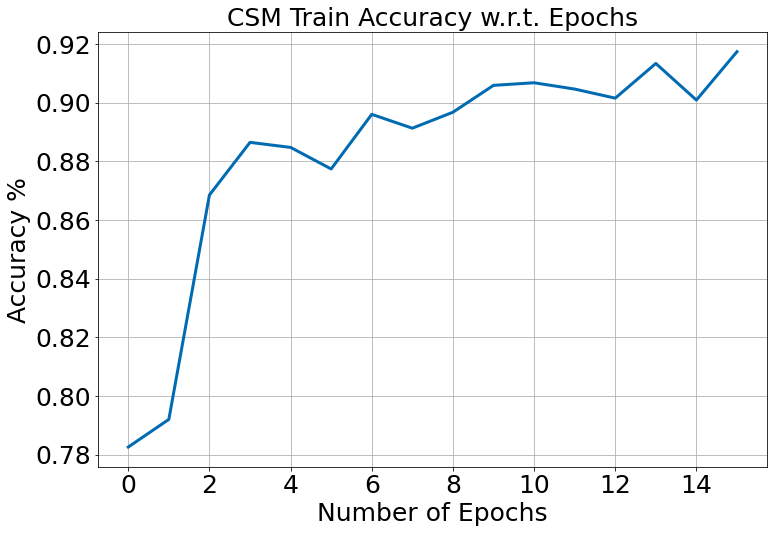

In [9]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'CSM Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

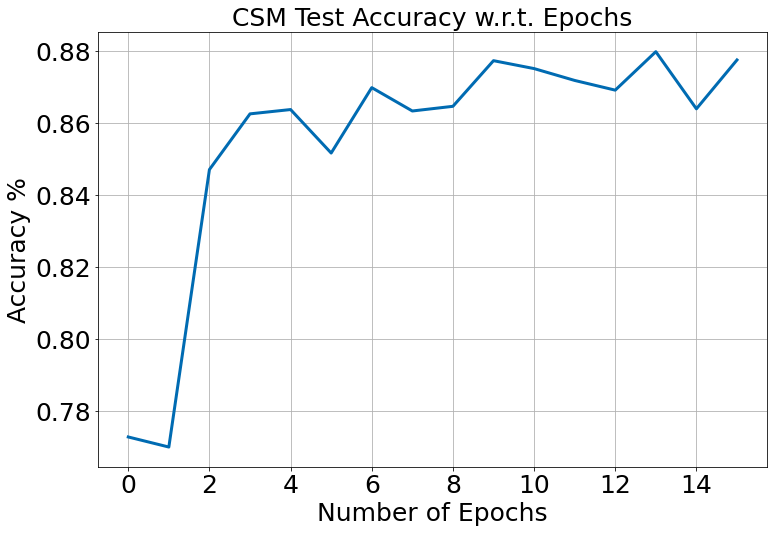

In [10]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'CSM Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)